Multimodal neural networks are a type of model designed to integrate data from multiple modalities, such as text, images, audio, video, or other data types. Multimodal networks aim to learn complex relationships between different kinds of inputs, with the hope of achieving better performance than a model focusing on a single modality. 

For example, in applications like video captioning, a multimodal network combines visual features from video frames with linguistic models to generate descriptive text. In tasks like audio-visual speech recognition, it can integrate auditory and visual data for more robust performance. By leveraging diverse types of data, multimodal neural networks improve the accuracy and context-awareness of machine learning systems, allowing for potentially deeper insights.

This post documents how to create a multimodal network for the purpose of quantifying roadway risk using traditional tabular features along with images of the surrounding region. The tabular features may describe the underlying network topology, or the number of traffic citations issued as a function of daily traffic volume, etc. Here a synthetic dataset will be used, but would be replaced with meaningful variables for real-world usage. 

For the purposes of demonstration, a small set of images are used: The Des Moines, Iowa metro region is partitioned into 16 equally sized tiles laid out in a 4x4 grid pattern: 


c:\Users\jtriv\miniforge3\envs\torch\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


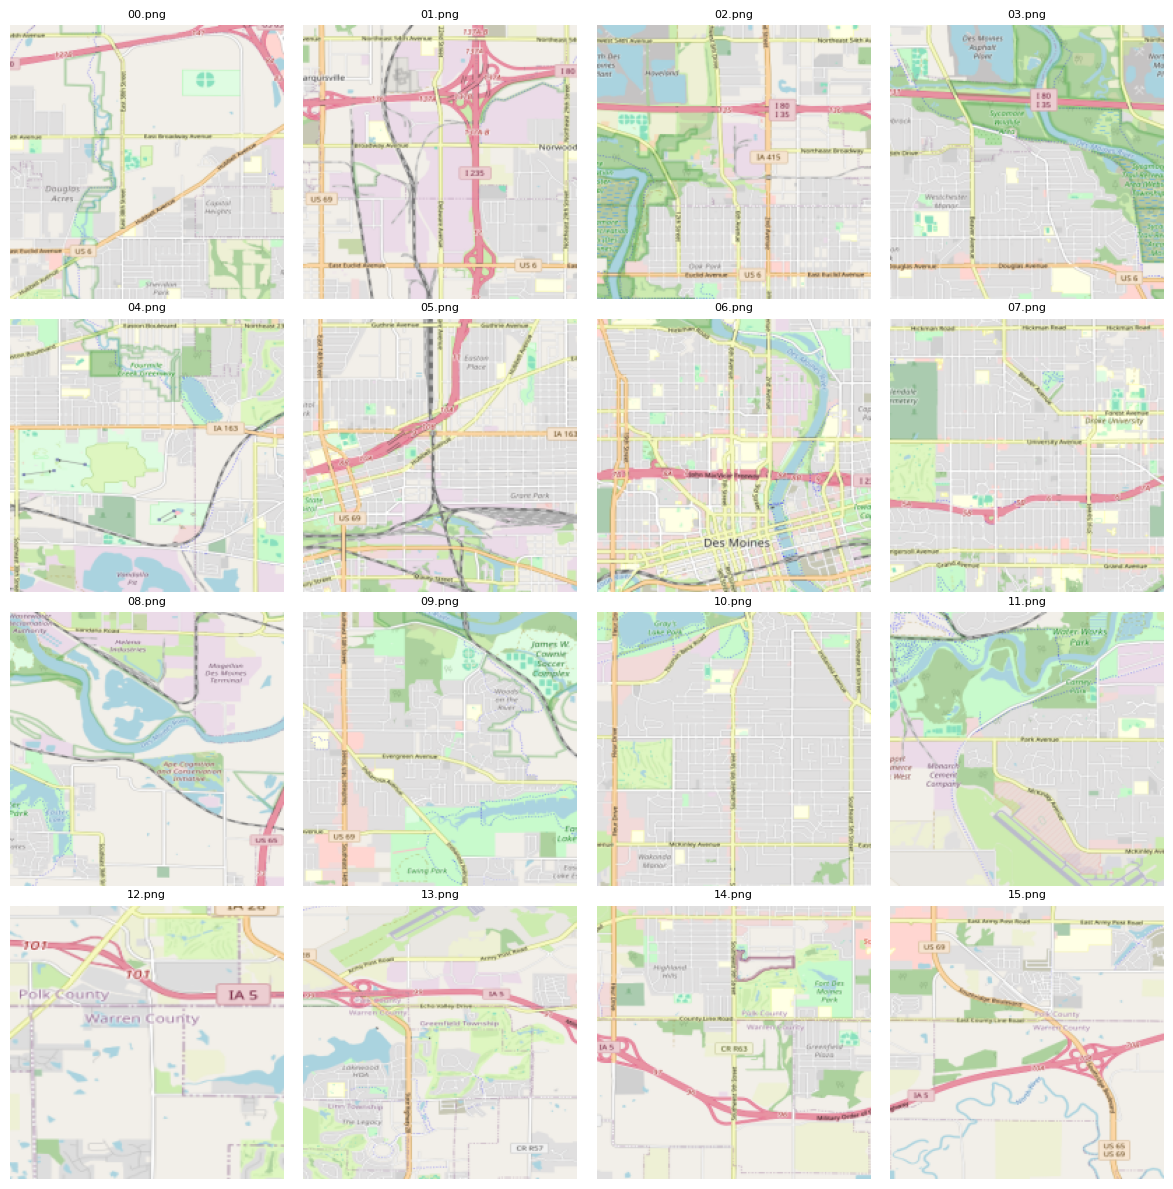

In [ ]:
# Create a grid of sample images.

import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

image_dir = Path("images")
image_paths = [image_dir.joinpath(f"{str(ii).zfill(2)}.png") for ii in range(16)]


fig = plt.figure(figsize=(12., 12.), tight_layout=False)

grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.20)

# Load images.
images = [cv2.cvtColor(cv2.imread(ii), cv2.COLOR_BGR2RGB)  for ii in image_paths]

# Resize to 196 x 196.
images = [cv2.resize(ii, (196, 196), interpolation=cv2.INTER_AREA) for ii in images]

for ax, path, img in zip(grid, image_paths, images):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(path.name, fontsize=8)

plt.show()


<br>

In practice, a much larger dataset with tens or hundreds of thousands of images would be used, but this small sample will suffice to demonstrate the approach. The setup used here can be specialized for different but similar task. 

A synthetic dataset is created to represent tabular features and label along with the path to the corresponding image file. Each row corresponds to one of the images shown in the grid above. For the label, *1* represents a region of high risk and *0* a region of low risk based on an auxiliary analysis:


In [2]:

import numpy as np
import pandas as pd
import torch

np.set_printoptions(suppress=True, precision=5)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option("display.precision", 5)

torch.manual_seed(516)
rng = np.random.default_rng(516)

# Create 20 random tabular features. df has the same number of rows as the
# number of images (16).
df = pd.DataFrame(rng.normal(size=(16, 20)))

# Add label.
df["label"] = rng.integers(0, high=2, size=16)

# Add path to corresponding image file.
df["image_path"] = [image_dir.joinpath(f"{str(ii).zfill(2)}.png") for ii in range(16)]

df.head(7)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,label,image_path
0,1.28963,0.48410,0.24857,0.73372,-0.98589,-0.32993,0.14570,-1.27563,0.33370,-1.23056,-0.54767,-0.42706,1.92863,0.82478,0.78189,-0.68096,1.84075,-0.58315,1.39984,1.98030,0,c:\Users\jtriv\repos\blog-posts-in-progress\mu...
1,-1.20795,0.30504,-0.62360,0.59993,0.12950,2.13616,0.24374,-0.68748,-2.42601,-0.10827,-3.08048,0.81488,1.87151,-1.50928,-0.93552,0.40171,-0.42437,-0.82750,-0.49901,0.69287,1,c:\Users\jtriv\repos\blog-posts-in-progress\mu...
2,0.29436,0.91876,-0.76522,0.34283,2.13044,-2.04926,1.72924,-0.08234,0.66696,-0.96648,-0.54479,-0.93761,0.46527,-0.81374,-0.45954,-0.46045,0.83743,0.33436,-0.10157,-1.33409,1,c:\Users\jtriv\repos\blog-posts-in-progress\mu...
3,-0.29149,0.40605,2.30611,-0.19939,1.56295,1.48744,0.99899,-0.05705,0.53843,1.20204,-1.36381,-0.78851,0.04786,-0.87854,-1.01904,-0.52666,-0.96457,-0.04617,1.71839,1.36298,0,c:\Users\jtriv\repos\blog-posts-in-progress\mu...
4,-1.04513,-2.56570,-0.52784,1.27892,-0.47038,-0.24379,-1.13843,-0.48612,1.41375,1.29564,-0.49210,-0.86928,2.09184,0.90340,0.38600,-0.63851,-1.43843,-0.79458,0.89424,-0.73609,0,c:\Users\jtriv\repos\blog-posts-in-progress\mu...
5,1.46810,-2.06851,-1.91358,-1.55112,-0.76136,0.25340,1.18610,-0.80685,-1.51704,-1.29806,-0.75313,-0.02666,1.32913,0.30397,-1.81921,-0.98140,-0.45354,-1.29872,0.13481,0.87467,0,c:\Users\jtriv\repos\blog-posts-in-progress\mu...
6,-0.43073,-0.81238,1.35071,-0.62312,-0.74979,0.53097,-0.13714,0.01988,-0.65419,-0.41824,-1.15486,0.37681,0.62695,0.75203,-0.88323,-0.44607,-1.04912,-0.49071,-0.28945,-0.66037,0,c:\Users\jtriv\repos\blog-posts-in-progress\mu...



<br>

In order to supply the model with training data, a custom `Dataset` object is created. It accepts the DataFrame created in the previous cell along with the desired image dimension.  The `__getitem__` method is overridden to return a dictionary consisting of the image, tabular features and label for a single training sample:

In [3]:

from PIL import Image
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import v2


class MultiModalDataset(Dataset):
    
    def __init__(self, df, image_dim):
        """
        Parameters
        ----------
        df: pd.DataFrame
            Contains image path, predictors and label.

        image_dim: int
            Shape of images used for training. 
        """
        img_transform = [
            v2.CenterCrop(image_dim),
            v2.ToImage(),
            v2.ToDtype(torch.float, scale=True)
        ]

        self.img_transform = v2.Compose(img_transform)
        self.img_paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()
        self.features = torch.from_numpy(df.drop(["image_path", "label"], axis=1).values).to(torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_path = str(self.img_paths[index])
        img = Image.open(img_path).convert("RGB")
        img = self.img_transform(img)
        label = self.labels[index]
        predictors = self.features[index, :]
        return {"image": img, "predictors": predictors, "label": label}



<br>

In total, three separate models need to be created: 

1. A convolutional neural network (CNN) to be trained on image data
2. A fully-connected network to be trained on tabular features
3. A combined network which concatenates activations from 1 and 2 and generates a prediction

A simple CNN is shown below, but any model can be used in its place. PyTorch's pre-trained weights and associated models are worth exploring, available [here](https://pytorch.org/vision/main/models.html).  

In [4]:
# Simple CNN for image data. 

import torch.nn as nn
import torch.nn.functional as F


class BasicCNN(nn.Module):
    def __init__(self, dropout=0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=4, kernel_size=5)
        self.fc1 = nn.Linear(in_features=529 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=64)
        self.drp = nn.Dropout(p=dropout)
        
    def forward(self, X):
        output = self.pool(F.relu(self.conv1(X)))
        output = self.pool(F.relu(self.conv2(output)))
        output = torch.flatten(output, 1)
        output = F.relu(self.drp(self.fc1(output)))
        output = F.relu(self.drp(self.fc2(output)))
        return output


# Print number of trainable parameters.
nbr_params = sum(p.numel() for p in BasicCNN().parameters())
print(f"BasicCNN number of parameters: {nbr_params:,.0f}")


BasicCNN number of parameters: 1,024,604



<br>

Within `self.fc1`, `in_features` is set to 529 * 4 * 4 = 8,464, which is the flattened shape coming out of `self.conv2` after the application of max pooling.

To use a pre-trained model, a different architecture is required. For example, to use ResNet34 trained on ImageNet data, a `PretrainedCNN` model is created:


In [5]:
# Pretrained CNN (ResNet34) for image data. 

import torch.nn as nn
from torchvision import models


class PretrainedCNN(nn.Module):
    def __init__(self, dropout=0):
        super().__init__()
        self.model = models.resnet34()

        # Set requires_grad to False for pretrained model. 
        for param in self.model.parameters():
            param.requires_grad = False

        # Get dimension of last layer input. 
        pt_num_features = self.model.fc.in_features
        
        self.model.fc = nn.Sequential(
             nn.Linear(in_features=pt_num_features, out_features=64),
             nn.Dropout(p=dropout),
             nn.ReLU(),
        )
        
    def forward(self, input):
        output = self.model(input)
        return output


# Print number of trainable parameters.
nbr_params = sum(p.numel() for p in PretrainedCNN().parameters())
print(f"PretrainedCNN number of parameters: {nbr_params:,.0f}")


PretrainedCNN number of parameters: 21,317,504



<br>

`PretrainedCNN` has many more parameters than  `BasicCNN`, but only weights associated with `self.model.fc` will be updated during backpropagation. All other weights have been frozen in the call to `param.requires_grad = False`. The actual number of trainable parameters for `PretrainedCNN` is closer to 30,000. 

Within the forward pass, both `BasicCNN` and `PretrainedCNN` return an activation tensor having dimension BATCH_SIZE x 64.

The model to process tabular features is a simple fully-connected network with two hidden layers:


In [6]:
# Model to process tabular features.

class TabularNN(nn.Module):
    def __init__(self, num_features, dropout=0):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=128, out_features=32)
        )
        
    def forward(self, input):
        output = self.model(input)
        return output
    

nbr_params = sum(p.numel() for p in TabularNN(20).parameters())
print(f"TabularNN number of parameters: {nbr_params:,.0f}")


TabularNN number of parameters: 13,792



<br>

`num_features` is the number of predictors in the tabular dataset (we used 20 for the synthetic data created earlier). Within the forward pass, `TabularNN` returns an activation tensor of dimension BATCH_SIZE x 32. 

In the next cell, `MultiModalNN` accepts an image model and a tabular model, along with the dimension of the activation output for each. The activations are concatenated row-wise, then passed through the sigmoid to generate an output between 0 and 1, where values closer to 1 represent higher risk regions.  `MultiModalNN` consists only of a single linear layer which reduces the dimensionality of the concatenated activations down to an output dimension BATCH_SIZE x 1. The `forward` method accepts both a batch of images and a batch of tabular features. 


In [7]:
# Multi-modal network. 

class MultiModalNN(nn.Module):
    def __init__(self, image_model, tabular_model, image_act_dim, tabular_act_dim, dropout=0):
        super().__init__()
        self.image_model = image_model
        self.tabular_model = tabular_model
        self.sigmoid = nn.Sigmoid()
        self.mm_model = nn.Sequential(
            nn.Linear(in_features=image_act_dim + tabular_act_dim, out_features=32),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=32, out_features=1)
        )

    def forward(self, images, predictors):
        image_activations = self.image_model(images)
        tabular_activations = self.tabular_model(predictors)
        output = torch.cat((image_activations, tabular_activations), dim=1)
        output = self.sigmoid(self.mm_model(output))
        return output
    


### Bringing it All Together

We first create a `MultiModalDataset` instance which gets passed into `DataLoader`. We use a batch size of 4 (8 samples for training, 4 for validation):



In [8]:
# Initialize DataLoaders.

batch_size = 4
image_dim = 196

# Use GPU if available. 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ds_train = MultiModalDataset(df[:12], image_dim=image_dim)
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

ds_valid = MultiModalDataset(df[12:], image_dim=image_dim)
valid_loader = DataLoader(ds_valid, batch_size=batch_size, shuffle=True)

print(f"device: {device}.")


device: cpu.



We can inspect a batch of training data and get the dimensions of the concatenated images and tabular features:

In [9]:

d = next(iter(train_loader))

print(f"d.keys()              : {list(d.keys())}")
print(f"d['image'].shape      : {d['image'].shape}")
print(f"d['predictors'].shape : {d['predictors'].shape}")
print(f"d['label'].shape      : {d['label'].shape}")


d.keys()              : ['image', 'predictors', 'label']
d['image'].shape      : torch.Size([4, 3, 196, 196])
d['predictors'].shape : torch.Size([4, 20])
d['label'].shape      : torch.Size([4])



<br>

To create a `MutliModalNN` instance, we first initialize the component models. Recall that for `BasicCNN`, the output will be BATCH_SIZE x 64 and for `TabularNN` BATCH_SIZE x 32. The optimizer is initialized, the loss function specified and code is added to train on multiple GPUs in parallel if available:

In [10]:

dropout = .10    # Dropout
ngpu = 1         # Number of GPUs 

# Create model instances.
cnn_model = BasicCNN(dropout=dropout)
tab_model = TabularNN(num_features=20, dropout=dropout)
mm_model = MultiModalNN(cnn_model, tab_model, image_act_dim=64, tabular_act_dim=32, dropout=dropout)

# Specify loss criteria and optimizer.
criterion = nn.BCELoss()
optim = torch.optim.Adam(mm_model.parameters(), lr=0.0002, betas=(.50, 0.999))

# Distribute model across multiple gpus if available.
if (device.type == "cuda") and (ngpu > 1):
	model = nn.DataParallel(mm_model, list(range(ngpu)))



<br>

As a quick verification, a batch of training data is passed into `mm_model` to ensure the correct output dimensionality:

In [11]:

images, predictors = d["image"], d["predictors"]
predictors = predictors.to(device=device, dtype=torch.float)
images = images.to(device=device, dtype=torch.float)
y = mm_model(images, predictors).squeeze()

print(f"y.shape: {y.shape}")

y

y.shape: torch.Size([4])


tensor([0.5056, 0.5047, 0.5080, 0.5011], grad_fn=<SqueezeBackward0>)


<br>

The training loop executes the following steps:

- Load a batch of training data from the DataLoader.
- Zero out the optimizer’s gradients.
- Get predictions from the model for current batch.
- Calculate the loss for current batch predictions vs. labels.
- Calculate backward gradients over the weights.
- Calculate the loss on a set of data that was not used for training.


`trainer` and `validator` are defined to handle the training and validation of a single epoch:

In [12]:

def trainer(epoch, model, train_loader, criterion, optim):
    """
    Train single epoch.
    """
    nbr_batches = len(train_loader)

    running_loss, checkpoint_loss = 0., 0.

    for ii, dinputs in enumerate(train_loader):

        images, predictors, yactual = dinputs["image"], dinputs["predictors"], dinputs["label"]
        predictors = predictors.to(device=device, dtype=torch.float)
        images = images.to(device=device, dtype=torch.float)
        yactual = yactual.to(device=device, dtype=torch.float)

        # Zero out gradients.
        optim.zero_grad()

        # Forward pass.
        ypred = model(images, predictors).squeeze()

        # Compute loss and gradients.
        loss = criterion(ypred, yactual)
        loss.backward()

        # Update weights.
        optim.step()

        running_loss+=loss.item()

        if ii % 100 == 0:
            checkpoint_loss = running_loss / 100
            print(f"\t+ [train][epoch={epoch}, batch={ii}] loss = {checkpoint_loss:,.5f}.")
            running_loss = 0.0

    return checkpoint_loss
       

def validator(epoch, model, valid_loader, criterion):
    """
    Validate single epoch.
    """
    with torch.no_grad():
        
        running_loss = 0.0

        for ii, dinputs in enumerate(valid_loader, start=1):
            images, predictors, yactual = dinputs["image"], dinputs["predictors"], dinputs["label"]
            predictors = predictors.to(device=device, dtype=torch.float)
            images = images.to(device=device, dtype=torch.float)
            yactual = yactual.to(device=device, dtype=torch.float)
            ypred = model(images, predictors).squeeze()
            loss = criterion(ypred, yactual)
            running_loss += loss.item()
        avg_valid_loss = running_loss / ii

    return avg_valid_loss



Then construct the training loop:

In [13]:

from datetime import datetime

epochs = 10
best_valid_loss = 1e15

for epoch in range(1, epochs + 1):

    mm_model.train()

    train_loss = trainer(epoch, mm_model, train_loader, criterion, optim)

    mm_model.eval()

    valid_loss = validator(epoch, mm_model, valid_loader, criterion)

    if valid_loss < best_valid_loss:
        model_path = f"epoch-{epoch}.pth"
        torch.save(mm_model, model_path)
        best_valid_loss = valid_loss


	+ [train][epoch=1, batch=0] loss = 0.00696.
	+ [train][epoch=2, batch=0] loss = 0.00690.
	+ [train][epoch=3, batch=0] loss = 0.00676.
	+ [train][epoch=4, batch=0] loss = 0.00658.
	+ [train][epoch=5, batch=0] loss = 0.00668.
	+ [train][epoch=6, batch=0] loss = 0.00648.
	+ [train][epoch=7, batch=0] loss = 0.00812.
	+ [train][epoch=8, batch=0] loss = 0.00723.
	+ [train][epoch=9, batch=0] loss = 0.00835.
	+ [train][epoch=10, batch=0] loss = 0.00585.



<br>

### Enhancements

As presented above, the map images have a lot of detail that may not be of particular interest for the task at hand. It may be desirable to create binary images that represent roadways in white and everything else black. This can be accomplished using a segmentation model such as U-Net. The multimodal architecture can also be expanded to incorporate multiple images per training sample.
